### Import libraries and load dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

tweet_train_path = "data/combine/kfolds_0/train.csv"
tweet_test_path = "data/combine/kfolds_0/test.csv"

train_df = pd.read_csv(tweet_train_path, nrows=50)
test_df = pd.read_csv(tweet_test_path, nrows=50)

train_df.head()

,tweet_id,label,text
0,567737449938685952,negative,@SouthwestAir no flights out of #nashville tod...
1,567737317432258560,neutral,@SouthwestAir I am but it says yall are sold o...
2,567736870365171713,negative,@SouthwestAir I'm trying to change a family va...
3,567736166787850240,neutral,@SouthwestAir F5R3ZZ
4,567735766416392194,positive,.@SouthwestAir you've got a mess here at DTW b...


### Data preprocessing

In [3]:
import re

def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet)) .strip()               
    return tweet

In [4]:
train_df["text"] = train_df["text"].apply(lambda x: process_tweet(x))
test_df["text"] = test_df["text"].apply(lambda x: process_tweet(x))
train_df.head()

,tweet_id,label,text
0,567737449938685952,negative,no flights out of nashville today are you kidd...
1,567737317432258560,neutral,am but it says yall are sold out me amp my cow...
2,567736870365171713,negative,trying to change family vacation due to measle...
3,567736166787850240,neutral,zz
4,567735766416392194,positive,you ve got mess here at dtw but your staff is ...


In [5]:
# Convert data to trainable format
id2label = {0: "negative", 1: "neutral", 2: "positive"}
label2id = {v: k for k, v in id2label.items()}

train_df["label"] = train_df["label"].apply(lambda x: label2id[x])
test_df["label"] = test_df["label"].apply(lambda x: label2id[x])

train_texts = train_df["text"].values
train_labels = train_df["label"].values

test_texts = test_df["text"].values
test_labels = test_df["label"]. values

train_texts[:5]

array(['no flights out of nashville today are you kidding me why are other airlines flying and you re not so frustrated',
       'am but it says yall are sold out me amp my coworkers would need to get out first available',
       'trying to change family vacation due to measles outbreak and haven been able to get anyone on the phone any help',
       'zz', 'you ve got mess here at dtw but your staff is doing great'],
      dtype=object)

### Select feature extraction method & model for training
Feature extraction heavily depends on the classifer. For example, language models such as bert-base-uncased and roberta-base don"t require feature extraction step. Other shallow learning models require feature extraction such as tf-idf, bow, word2vec to transform texts to vectors.

In [6]:
from vectorizers import init_vectorizer

vectorizer_options = [
    "tfidf",
    "word2vec",
    "bow", # unigram and bigram
    "pass" # only use for lm_models
]

chosen_vectorizer_name = vectorizer_options[2]
vectorizer = init_vectorizer(chosen_vectorizer_name)
print("Vectorizer: ", chosen_vectorizer_name)

Vectorizer:  bow


### Feature Extraction

In [7]:
# Train vectorizer
vectorizer.fit(train_texts)

# convert train_texts, test_texts to vectors
train_vector = vectorizer.transform(train_texts)
test_vector = vectorizer.transform(test_texts)

train_vector[:5]

<5x882 sparse matrix of type '<class 'numpy.int64'>'
	with 140 stored elements in Compressed Sparse Row format>

### Training model

In [8]:
# all classifer options
from algorithms import init_trainer

shallow_learning_models = [
    "linear_svm", #0
    "logistic_regressor", #2
    "naive_bayes", #3
    "random_forest"  #4
    ]

lm_models = [
    "distilbert-base-uncased", #5
    "bert-base-uncased", #6
    "roberta-base", #7
]

In [9]:
import time

all_metrics = {
    "training_times": []
}

chosen_models = shallow_learning_models + lm_models

for chosen_model_name in chosen_models:
    print(f"Training model {chosen_model_name}")

    trainer = init_trainer(chosen_model_name)

    straining_time = time.time()

    if chosen_model_name in lm_models: # LM models don't require feature extraction step
        trainer.train(train_texts, train_labels)
    else:
        trainer.train(train_vector, train_labels)

    training_time = time.time() - straining_time

    all_metrics["training_times"].append(training_time)

    trainer.save_model(vectorizer=vectorizer, output_model_name=f"{chosen_model_name}-example")

    # evaluate
    if chosen_model_name in lm_models:
        metrics = trainer.evaluate(test_texts, test_labels)
    else:
        metrics = trainer.evaluate(test_vector, test_labels)
    
    for metric, score in metrics.items():
        if metric not in all_metrics:
            all_metrics[metric] = []
        all_metrics[metric].append(score)

Training model linear_svm
Model has been saved to models/linear_svm-example
Accuracy: micro: 0.560
Precision: micro-macro: 0.560-0.598
Recall: micro-macro: 0.560-0.584
F1: micro-macro: 0.560-0.545
              precision    recall  f1-score   support

    negative       0.60      0.80      0.69        15
     neutral       0.48      0.69      0.56        16
    positive       0.71      0.26      0.38        19

    accuracy                           0.56        50
   macro avg       0.60      0.58      0.54        50
weighted avg       0.60      0.56      0.53        50

Training model logistic_regressor
Model has been saved to models/logistic_regressor-example
Accuracy: micro: 0.560
Precision: micro-macro: 0.560-0.675
Recall: micro-macro: 0.560-0.584
F1: micro-macro: 0.560-0.543
              precision    recall  f1-score   support

    negative       0.55      0.80      0.65        15
     neutral       0.48      0.69      0.56        16
    positive       1.00      0.26      0.42   

/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 20
  Number of trainable parameters = 66955779
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast t

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to models/distilbert-base-uncased-example
Configuration saved in models/distilbert-base-uncased-example/config.json
Model weights saved in models/distilbert-base-uncased-example/pytorch_model.bin
tokenizer config file saved in models/distilbert-base-uncased-example/tokenizer_config.json
Special tokens file saved in models/distilbert-base-uncased-example/special_tokens_map.json


Model has been saved to models/distilbert-base-uncased-example


Parameter 'function'=<function LMForSequenceClassification.preprocess_function at 0x7fe6e403ea60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50
  Batch size = 2


Accuracy: micro: 0.300
Precision: micro-macro: 0.300-0.100
Recall: micro-macro: 0.300-0.333
F1: micro-macro: 0.300-0.154
              precision    recall  f1-score   support

    negative       0.30      1.00      0.46        15
     neutral       0.00      0.00      0.00        16
    positive       0.00      0.00      0.00        19

    accuracy                           0.30        50
   macro avg       0.10      0.33      0.15        50
weighted avg       0.09      0.30      0.14        50

Training model bert-base-uncased


/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50
  Num Epochs = 5
  Instantaneous batch

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to models/bert-base-uncased-example
Configuration saved in models/bert-base-uncased-example/config.json
Model weights saved in models/bert-base-uncased-example/pytorch_model.bin
tokenizer config file saved in models/bert-base-uncased-example/tokenizer_config.json
Special tokens file saved in models/bert-base-uncased-example/special_tokens_map.json


Model has been saved to models/bert-base-uncased-example


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50
  Batch size = 2


Accuracy: micro: 0.400
Precision: micro-macro: 0.400-0.354
Recall: micro-macro: 0.400-0.438
F1: micro-macro: 0.400-0.317
              precision    recall  f1-score   support

    negative       0.35      1.00      0.52        15
     neutral       0.71      0.31      0.43        16
    positive       0.00      0.00      0.00        19

    accuracy                           0.40        50
   macro avg       0.35      0.44      0.32        50
weighted avg       0.33      0.40      0.29        50

Training model roberta-base


/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50
  Num Epochs = 5
  Instantaneous

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to models/roberta-base-example
Configuration saved in models/roberta-base-example/config.json
Model weights saved in models/roberta-base-example/pytorch_model.bin
tokenizer config file saved in models/roberta-base-example/tokenizer_config.json
Special tokens file saved in models/roberta-base-example/special_tokens_map.json


Model has been saved to models/roberta-base-example


  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 50
  Batch size = 2


Accuracy: micro: 0.300
Precision: micro-macro: 0.300-0.100
Recall: micro-macro: 0.300-0.333
F1: micro-macro: 0.300-0.154
              precision    recall  f1-score   support

    negative       0.30      1.00      0.46        15
     neutral       0.00      0.00      0.00        16
    positive       0.00      0.00      0.00        19

    accuracy                           0.30        50
   macro avg       0.10      0.33      0.15        50
weighted avg       0.09      0.30      0.14        50



/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/thanhdat/DATA/Projects/Sentiment-Analysis-Benchmark/.env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

### Visualize results

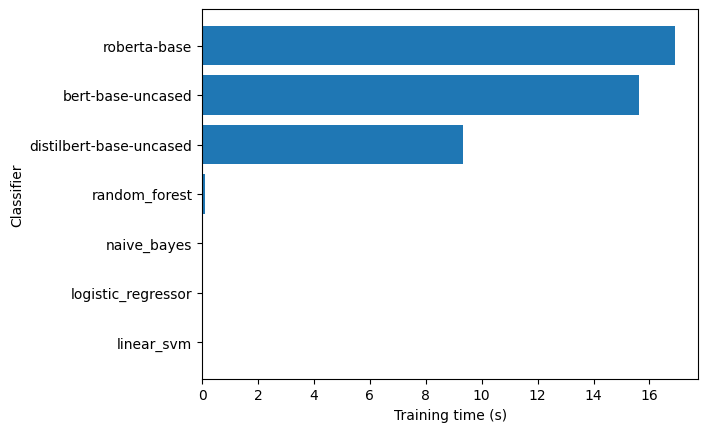

In [12]:
import matplotlib.pyplot as plt

plt.figure(dpi=100)
plt.barh(chosen_models, all_metrics["training_times"])
plt.ylabel("Classifier")
plt.xlabel("Training time (s)")
plt.show()

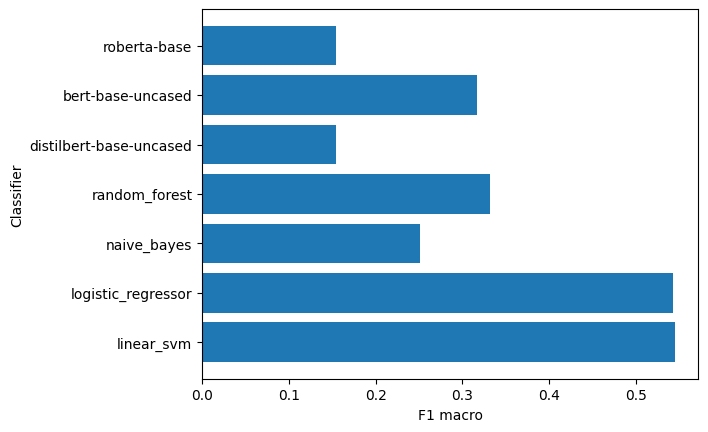

In [13]:
plt.figure(dpi=100)
plt.barh(chosen_models, all_metrics["f1_macro"])
plt.ylabel("Classifier")
plt.xlabel("F1 macro")
plt.show()

In [ ]:
plt.figure(dpi=100)
plt.barh(chosen_models, all_metrics["inference_time"])
plt.ylabel("Classifier")
plt.xlabel("Inference Time (s)")
plt.show()